# Time Series Model for Daily Female Birth Using Python
### David Lowe
### August 14, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

SUMMARY: The purpose of this project is to construct a time series prediction model and document the end-to-end steps using a template. The Daily Female Births dataset is a time series situation where we are trying to forecast future outcomes based on past data points.

INTRODUCTION: The problem is to predict daily births of female. The dataset describes the daily number of female births in California in 1959, and there are 365 observations. We used 334 observations from the first 11 months for training and testing various models, while holding back 31 observations (from the last month) for validating the final model. The original dataset was credited to Newton (1988).

ANALYSIS: The baseline prediction (or persistence) for the dataset resulted in an RMSE of 8.72. After performing a grid search for the most optimal ARIMA parameters, the RMSE of the final ARIMA(1, 1, 4) model was 6.93. Furthermore, the final model processed the validation data with an RMSE of 6.64.

CONCLUSION: For this dataset, the ARIMA model with the order of (1, 1, 4) achieved the best overall results and should be considered for further modeling.

Dataset Used: Daily Female Births in California in 1959

Dataset ML Model: Time series forecast with numerical attributes

Dataset Reference: https://datamarket.com/data/set/235k/daily-total-female-births-in-california-1959

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end
* Explore data cleaning and transformation options
* Explore various algorithms for baselining the model performance
* Explore tuning techniques for improving the model performance

A time series predictive modeling project genrally can be broken down into about five major tasks:

1. Define Problem and Acquire Data
2. Inspect and Explore Data
3. Clean and Pre-Process Data
4. Fit and Evaluate Models
5. Finalize and Deploy Model

## Section 1. Define Problem and Acquire Data

### 1.a) Load Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib
import warnings
from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### 1.b) Set up the controlling parameters and functions

In [6]:
# Create the random seed number for reproducible results
seedNum = 888

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = True

In [7]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [8]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

The dataset is not current. This means that we cannot easily collect updated data to validate the model. Therefore, we will pretend that it is November 30, 1959 and withhold the last 31 days of data from analysis and model selection. This very last month of data will be used to validate the final model.

The code below will load the dataset as a Pandas Series and split into two, one for model development (dataset.csv) and the other for validation (validation.csv). The specific contents of these files are:

* dataset.csv: Observations from January to November 1959 (334 observations).
* validation.csv: Observations from December 1959 (31 observations).

The validation dataset is about 9% of the original dataset.

In [9]:
startTimeScript = datetime.now()

In [10]:
# Split the time series data into a training and validation dataset
series = pd.read_csv('daily-female-births.csv', index_col=0, parse_dates=True)
split_point = len(series) - 31
dataset, validation = series[0:split_point], series[split_point:]

In [11]:
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
Births    365 non-null int64
dtypes: int64(1)
memory usage: 5.7 KB


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1959-01-01 to 1959-11-30
Data columns (total 1 columns):
Births    334 non-null int64
dtypes: int64(1)
memory usage: 5.2 KB


In [13]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 1959-12-01 to 1959-12-31
Data columns (total 1 columns):
Births    31 non-null int64
dtypes: int64(1)
memory usage: 496.0 bytes


In [14]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2. Inspect and Explore Data

In [15]:
if (notifyStatus): email_notify("Data Inspection and Exploration has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [16]:
# Summary statistics of time series
print(series.describe())

           Births
count  365.000000
mean    41.980822
std      7.348257
min     23.000000
25%     37.000000
50%     42.000000
75%     46.000000
max     73.000000


### 2.b) Line Plot of the Time Series Data

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:

* Whether the trend appears to be level around the mean
* Whether there appear to be any obvious outliers

There may be some benefit in explicitly modeling the trend component and removing it. We may also explore using differencing with one or two levels in order to make the series stationary.

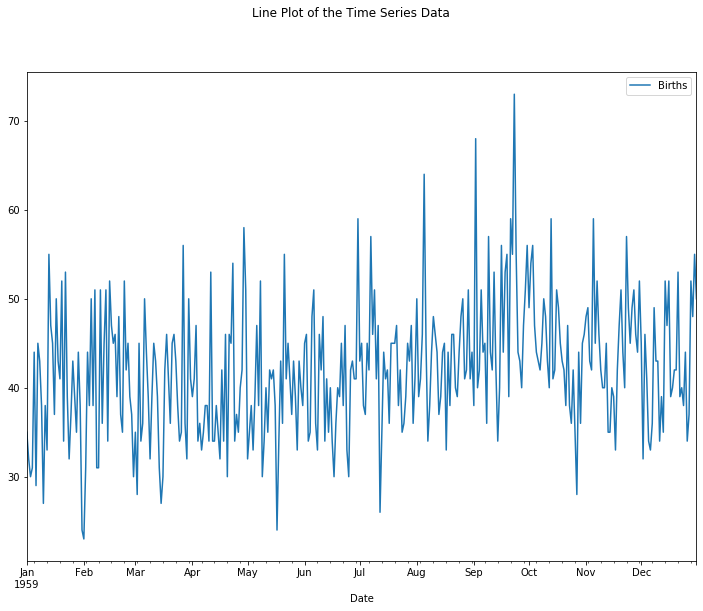

In [17]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Time Series Data')
series.plot(ax=ax)
plt.show()

### 2.c) Histogram and Density Plots of the Time Series Data

Reviewing plots of the density of observations can provide further insight into the structure of the data. Some observations from the plots can include:

* Whether the distribution is Gaussian
* Whether the distribution has a long tail and may suggest the need for data transformation

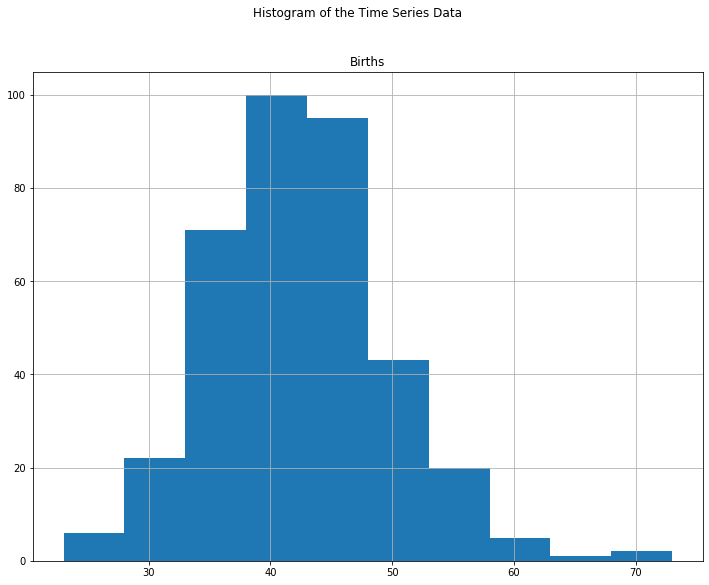

In [18]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Histogram of the Time Series Data')
series.hist(ax=ax)
plt.show()

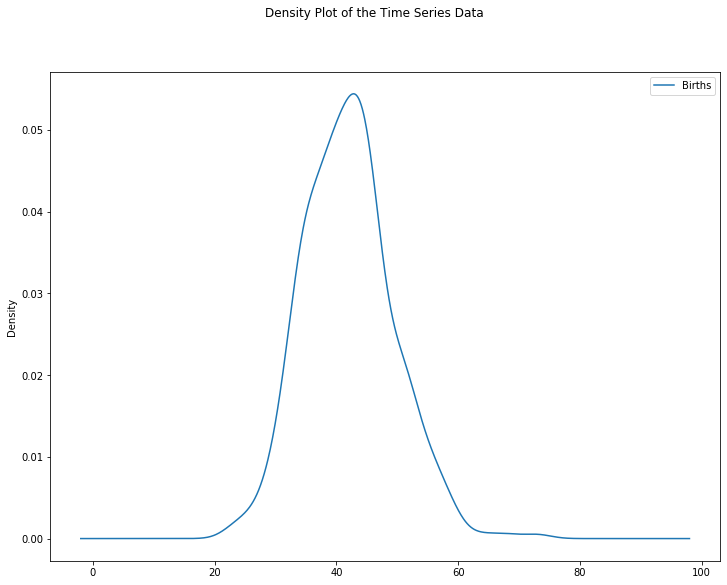

In [19]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Density Plot of the Time Series Data')
series.plot(kind='kde', ax=ax)
plt.show()

### 2.d) Box and Whisker Plots of the Time Series Data

We can group or aggregate the data and get a better idea of the spread of observations. Some observations from reviewing the plot can include:

* Whether the median values for each grouping shows any significant trend
* Whether the spread, or middle 50% of the data, shows any significant variability
* Whether there are outliers in some grouping

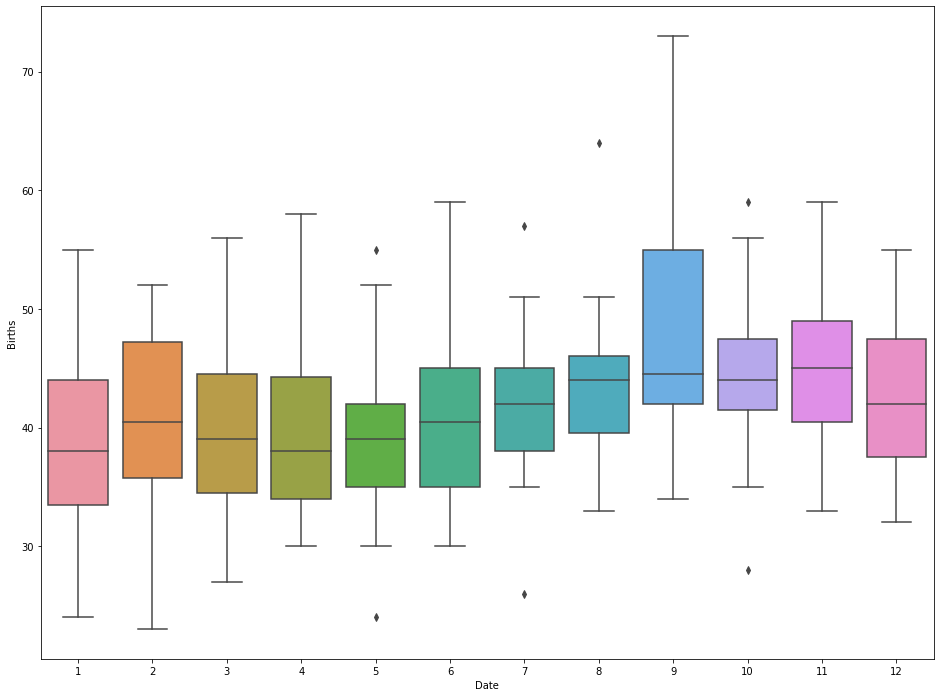

In [20]:
# boxplots of time series
fig, ax = plt.subplots(figsize=(16,12))
squeezed = series.squeeze()
sns.boxplot(squeezed.index.month, squeezed, ax=ax)
plt.show()

In [21]:
if (notifyStatus): email_notify("Data Inspection and Exploration completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3. Clean and Pre-Process Data

In [22]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

This section currently is not applicable to this iteration of the project.

In [23]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 4. Fit and Evaluate Models

In this section, we will develop Autoregressive Integrated Moving Average or ARIMA models for the problem. We will first establish a persistent model. Next we will use a grid search approach to look for an optimal ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model.

* Establish the Persistent Model
* Automatically Configure the ARIMA
* Review Residual Errors

In [24]:
if (notifyStatus): email_notify("Model Fitting and Evaluation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Establish the Persistent Model

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

Candidate models will be evaluated using walk-forward validation. This is because a rolling-forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data.

The walk-forward validation will work as follows:

* The first 50% of the dataset will be held back to train the model
* The remaining 50% of the dataset will be iterated and test the model
* For each step in the test dataset:
    * A model will be trained
    * A one-step prediction made and the prediction stored for later evaluation
    * The actual observation from the test dataset will be added to the training dataset for the next iteration
* The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported

Given the small size of the data, we will allow a model to be re-trained given all available data prior to each prediction.

#### 4.a.i) Statistical Test for the Stationarity of the Time Series Data

The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually. Analysis of the time series data assumes that we are working with a stationary time series.

Occasionally a time series is non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary.

The ADF results might show that the test statistic value is smaller than the critical value at 5%. This suggests that we can reject the null hypothesis (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. This suggests that at least one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1.

ADF Statistic: -12.625179
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


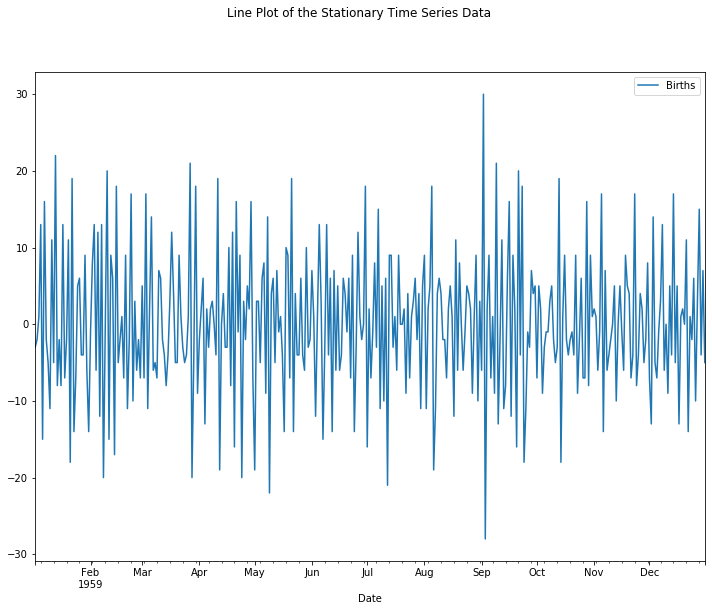

In [25]:
# Create a differenced series
stationary = series.diff().dropna()

# Check if stationary
result = adfuller(stationary['Births'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Time Series Data')
stationary.plot(ax=ax)
plt.show()

#### 4.a.ii) ACF and PACF Plots of the Time Series Data

The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

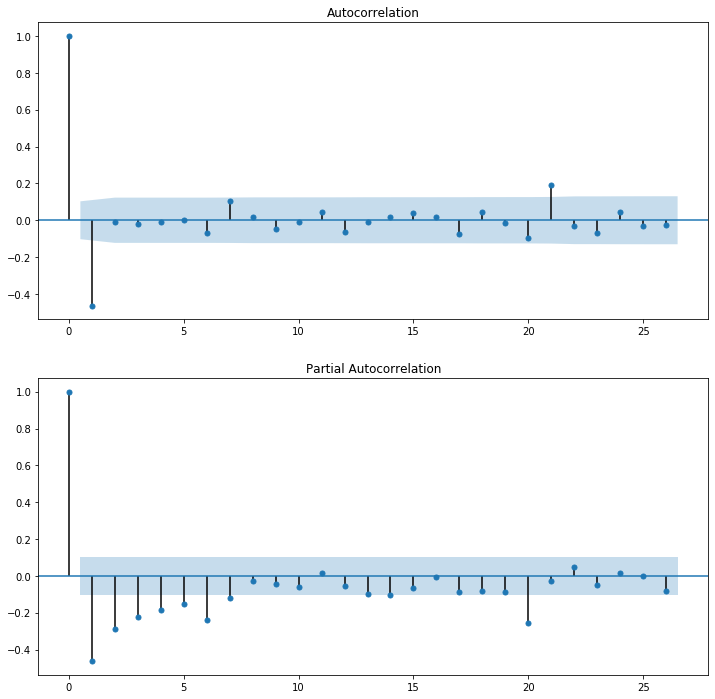

In [26]:
# ACF and PACF plots of the stationary time series
fig = plt.figure(figsize=(12,12))
plt.figure(1)
plt.subplot(211)
plot_acf(stationary, ax=plt.gca())
plt.subplot(212)
plot_pacf(stationary, ax=plt.gca())
plt.show()

#### 4.a.iii) Establish the Persistent Model as Baseline

In [27]:
# Prepare and evaluate a persistence model
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# Calculate performance
rmse = math.sqrt(mean_squared_error(test, predictions))
print('RMSE for the persistent model is: %.3f' % rmse)

>Predicted=43.000, Expected= 45
>Predicted=45.000, Expected= 38
>Predicted=38.000, Expected= 37
>Predicted=37.000, Expected= 45
>Predicted=45.000, Expected= 42
>Predicted=42.000, Expected= 57
>Predicted=57.000, Expected= 46
>Predicted=46.000, Expected= 51
>Predicted=51.000, Expected= 41
>Predicted=41.000, Expected= 47
>Predicted=47.000, Expected= 26
>Predicted=26.000, Expected= 35
>Predicted=35.000, Expected= 44
>Predicted=44.000, Expected= 41
>Predicted=41.000, Expected= 42
>Predicted=42.000, Expected= 36
>Predicted=36.000, Expected= 45
>Predicted=45.000, Expected= 45
>Predicted=45.000, Expected= 45
>Predicted=45.000, Expected= 47
>Predicted=47.000, Expected= 38
>Predicted=38.000, Expected= 42
>Predicted=42.000, Expected= 35
>Predicted=35.000, Expected= 36
>Predicted=36.000, Expected= 39
>Predicted=39.000, Expected= 45
>Predicted=45.000, Expected= 43
>Predicted=43.000, Expected= 47
>Predicted=47.000, Expected= 36
>Predicted=36.000, Expected= 41
>Predicted=41.000, Expected= 50
>Predict

### 4.b) Grid Search of ARIMA Hyperparameters

We want to find a model that can do better than the persistence model on this dataset. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values.

We will also disable the automatic addition of a trend constant from the model by setting the ‘trend‘ argument to ‘nc‘ for no constant when calling fit().

In [28]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [29]:
# Do a grid search ARIMA parameters for a time series
# Set up function for evaluating an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = math.sqrt(mean_squared_error(test, predictions))
    return rmse

# Set up function for evaluating combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    print('WARNING: Model Order', order, ' did not converge!')
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# Based on ACF and PACF, we set the grid search parameters
p_values = range(0, 2)
d_values = range(1, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 1, 1) RMSE=7.075
ARIMA(0, 1, 2) RMSE=7.001
ARIMA(0, 2, 1) RMSE=8.722
ARIMA(1, 1, 0) RMSE=7.845
ARIMA(1, 1, 1) RMSE=6.991
ARIMA(1, 1, 2) RMSE=7.000
ARIMA(1, 1, 3) RMSE=6.981
ARIMA(1, 1, 4) RMSE=6.939
ARIMA(1, 2, 0) RMSE=11.364
Best ARIMA(1, 1, 4) RMSE=6.939


In [30]:
# Set the optimal ARIMA order parameters for later uses in the script
optimal_order = (1, 1, 4)

In [31]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Evaluate the Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

In [32]:
if (notifyStatus): email_notify("Residual Errors Evaluation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

                0
count  183.000000
mean     0.808157
std      6.910448
min    -15.300525
25%     -3.893425
50%      0.028051
75%      5.038183
max     27.166998


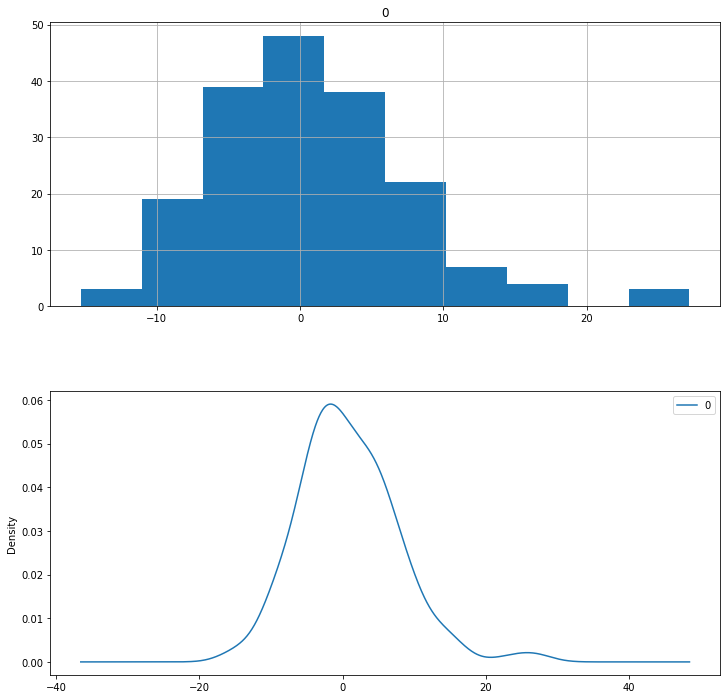

In [33]:
# Summarize residual errors for an ARIMA model
# Prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=optimal_order)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)

# Summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

# Plot residual errors
fig = plt.figure(figsize=(12,12))
plt.figure(1)
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

In [34]:
if (notifyStatus): email_notify("Residual Errors Evaluation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [35]:
if (notifyStatus): email_notify("Model Fitting and Evaluation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize and Deploy Model

After models have been developed and a final model selected, it must be validated and finalized. Validation is an optional part of the process, but one that provides a ‘last check’ to ensure we have not fooled or lied to ourselves.

This section includes the following steps:

* Finalize Model: Train and save the final model
* Make Prediction: Load the finalized model and make a prediction
* Validate Model: Load and validate the final model

In [36]:
if (notifyStatus): email_notify("Model Finalization and Deployment has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Finalize Model

Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case, on a transformed version of the entire dataset. Once fit, the model can be saved to file for later use.

In [37]:
# Prepare the finalized model for prediction
# prepare data
X = series.values
X = X.astype('float32')
# fit model
model = ARIMA(X, order=optimal_order)
model_fit = model.fit(trend='nc', disp=0)
print('The final model AIC score:', model_fit.aic)
print('The final model BIC score:', model_fit.bic)

The final model AIC score: 2459.7937696933395
The final model BIC score: 2483.17669289916


### 5.b) Validate Model

We can load the model and use it in a pretend operational manner. In the test harness section, we saved the final 10 years of the original dataset in a separate file to validate the final model.

We can load this validation.csv file now and use it to see how well our model really is on “unseen” data. There are two ways we might proceed:

* Load the model and use it to forecast the next X periods. The forecast beyond the first one or two years will quickly start to degrade in skill
* Load the model and use it in a rolling-forecast manner, updating the transform and model for each time step. This is the preferred method as it is how one would use this model in practice as it would achieve the best performance

As with model evaluation in the previous sections, we will make predictions in a rolling-forecast manner. This means that we will step over lead times in the validation dataset and take the observations as an update to the history.

Predictions from the validation data:
>Predicted=44.634, Expected= 45
>Predicted=45.423, Expected= 32
>Predicted=42.745, Expected= 46
>Predicted=44.563, Expected= 41
>Predicted=43.699, Expected= 34
>Predicted=43.205, Expected= 33
>Predicted=41.420, Expected= 36
>Predicted=42.515, Expected= 49
>Predicted=43.669, Expected= 43
>Predicted=44.039, Expected= 43
>Predicted=43.160, Expected= 34
>Predicted=42.039, Expected= 39
>Predicted=42.055, Expected= 35
>Predicted=41.471, Expected= 52
>Predicted=44.131, Expected= 47
>Predicted=43.738, Expected= 52
>Predicted=45.249, Expected= 39
>Predicted=42.492, Expected= 40
>Predicted=43.262, Expected= 42
>Predicted=42.176, Expected= 42
>Predicted=43.728, Expected= 53
>Predicted=44.066, Expected= 39
>Predicted=43.727, Expected= 40
>Predicted=42.178, Expected= 38
>Predicted=42.545, Expected= 44
>Predicted=42.783, Expected= 34
>Predicted=41.801, Expected= 37
>Predicted=41.368, Expected= 52
>Predicted=43.952, Expected= 48
>Predicted=43.936, Expected= 55
>P

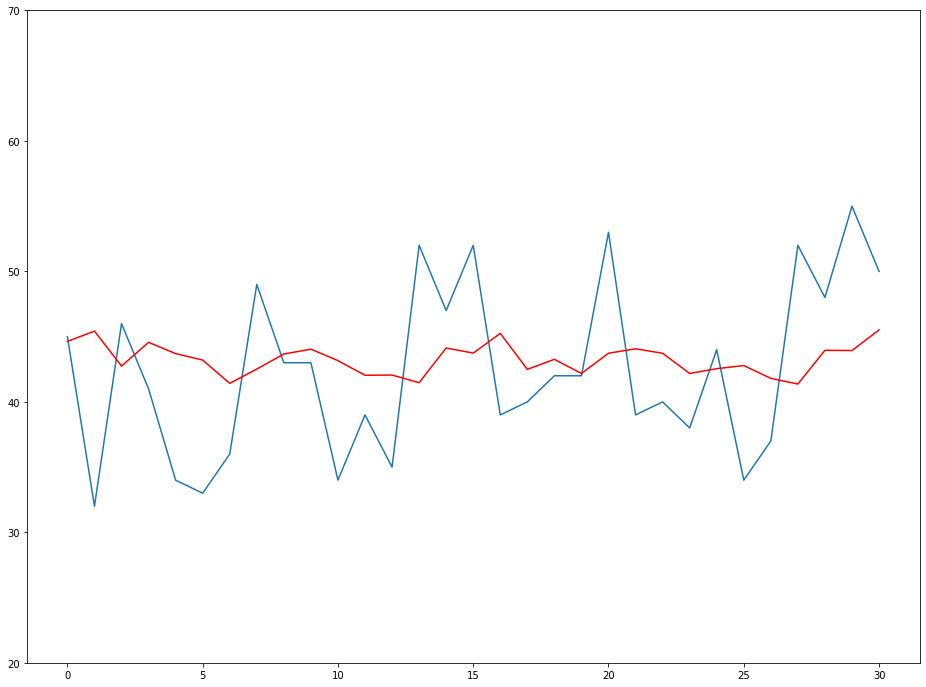

In [38]:
# load and evaluate the finalized model on the validation dataset
# load and prepare datasets
X = dataset.values.astype('float32')
history = [x for x in X]
y = validation.values.astype('float32')

# Make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('Predictions from the validation data:')
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# Do the rolling forecasts
for i in range(1, len(y)):
    model = ARIMA(history, order=optimal_order)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = float(model_fit.forecast()[0])
    predictions.append(yhat)
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE from the validation data is: %.3f' % rmse)

fig = plt.figure(figsize=(16,12))
plt.ylim(20,70)
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()

In [39]:
if (notifyStatus): email_notify("Model Finalization and Deployment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:06:09.875646
